# Kaggle Competition: Automated Essay Scoring
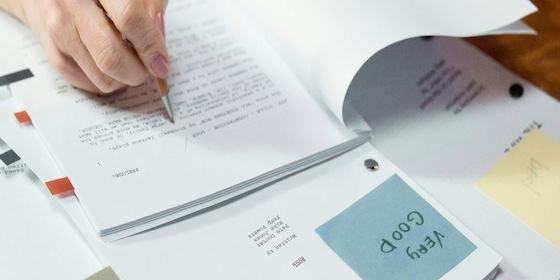

# [Kaggle Overview](https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2/data)

The first automated essay scoring competition to tackle automated grading of student-written essays was twelve years ago. How far have we come from this initial competition? With an updated dataset and light years of new ideas we hope to see if we can get to the latest in automated grading to provide a real impact to overtaxed teachers who continue to have challenges with providing timely feedback, especially in underserved communities.

The goal of this competition is to train a model to score student essays. Your efforts are needed to reduce the high expense and time required to hand grade these essays. Reliable automated techniques could allow essays to be introduced in testing, a key indicator of student learning that is currently commonly avoided due to the challenges in grading.

# Business Problem

The Educational Testing Industry is developing a tool to assist with evaluating student learning and performance on short answer responses and essays on standardized tests. Manual grading of essays is not only time-consuming but also resource-intensive, making it difficult for educators to provide timely feedback, especially in underserved communities. Automated Writing Evaluation (AWE) systems offer a solution by efficiently scoring essays and supplementing educators' efforts, allowing students to receive regular and prompt feedback on their writing.

<br>

This project supports the technical development team to explore several key model training and performance questions:
1.   What are the optimal hyperparameters for the models tested?
2.   How do different vectorization techniques (e.g., TF-IDF vs. BERT) impact the model's performance?
3. What is the effect of different model architectures on grading accuracy?



# [Kaggle Data Understanding](https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2/data)

The competition dataset comprises about 24000 student-written argumentative essays. Each essay was scored on a scale of 1 to 6 (Link to the Holistic Scoring Rubric [rubric](https://storage.googleapis.com/kaggle-forum-message-attachments/2733927/20538/Rubric_%20Holistic%20Essay%20Scoring.pdf)). Your goal is to predict the score an essay received from its text.

File and Field Information

**train.csv** - Essays and scores to be used as training data.

**essay_id** - The unique ID of the
essay

**full_text** - The full essay response

**score** - Holistic score of the essay on a 1-6 scale

**test.csv** - The essays to be used as test data. Contains the same fields as train.csv, aside from exclusion of score. (Note: The rerun test set has approximately 8k observations.)

**sample_submission.csv** - A submission file in the correct format.

**essay_id** - The unique ID of the essay
score - The predicted holistic score of the essay on a 1-6 scale

## General Project Roadmap







<div>
<img src="https://drive.google.com/uc?export=view&id=1TK2Odz0pimlXoNQ8HyW7wNWw2OvFA-1O" width="300"/>
</div>

# Import Libraries

In [39]:
%%capture

# Install necessary libraries
!pip install contractions
!pip install --upgrade keras-nlp
!pip install --upgrade keras
!pip install tensorflow==2.8.0
!pip install transformers==4.18.0
!pip install keras_tuner


In [40]:
#Import libraries for system operations and environment management
import sys
import os

# Print Python version to ensure compatibilitiy
print("Python version:")
print(sys.version)
print()


# Function to get the name of the virtual environment
def get_environment_name():
    """
    Retrieves the name of the current virtual environment, if one is active.

    Returns:
        str: The name of the virtual environment or a message indicating that no virtual environment is detected.
    """
    venv = os.getenv('VIRTUAL_ENV')
    if venv:
        return os.path.basename(venv)
    else:
        return "No virtual environment detected"

# Print environment name
print("Environment name:")
print(get_environment_name())


Python version:
3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]

Environment name:
No virtual environment detected


<div style="display: inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1PHKM3Ik2yCg-Y8_IdtzeFPwO3qdiCU0T" width="40"/>
 <font color='#3B528BFF'> <i>Ensuring the correct execution environment in Google Colab is crucial for compatibility with required libraries and their versions. This setup verifies that the environment supports the versions of the libraries needed for this project.</i></font> </div>


In [41]:
# Import Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import Counter
import re

# 3D plotting
from mpl_toolkits.mplot3d import Axes3D

# Scikit-learn for machine learning
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.cluster import KMeans

# TensorFlow and Keras for deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import keras_tuner as kt

# Transformers and Keras NLP libraries
from transformers import BertTokenizer, TFBertModel
import keras_nlp
import keras.backend as K

# NLTK for natural language processing
import nltk
from nltk.tokenize import word_tokenize
import contractions

# WordCloud
from wordcloud import WordCloud

# Download necessary NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Initialize the inflect engine for converting numbers to words
import inflect
p = inflect.engine()

# Define Constants for feature extraction and modeling
MAX_FEATURES = 768
NUM_CLUSTERS = 5
NUM_CLASSES = 6
EPOCHS = 100
BATCH_SIZE = 32
SEED = 0

# Set colormap for visualizations
cmap = mpl.cm.get_cmap('viridis')

# Ensure reproducibility
np.random.seed(SEED)


<ipython-input-41-52486ae6319b>:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('viridis')


<div style="display: inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1PHKM3Ik2yCg-Y8_IdtzeFPwO3qdiCU0T" width="40"/>
<font color='#3B528BFF'> <i>This code segment configures the backend engine for Keras, a high-level neural networks API, enhancing the computational efficiency of model training and execution. The available options include 'jax' for leveraging Google's JAX for autograd and XLA capabilities, 'tensorflow' for using TensorFlow's scaling and deployment features, and 'torch' for utilizing PyTorch's computation graphs and simple debugging.</i></font> </div>


# Import Data

In [42]:
#Displaying the current working directory of the Colab notebook.
!pwd

/content


<div style="display: inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1PHKM3Ik2yCg-Y8_IdtzeFPwO3qdiCU0T" width="40"/>
<font color='#3B528BFF'> <i> This information is crucial in a collaborative environment where multiple projects might be managed concurrently by different team members.</i></font> </div>


In [43]:
# Load the dataset from a CSV file into a Pandas DataFrame
essay_df = pd.read_csv('sample_data/train.csv')

# Select all 6000 rows from the dataset; optional adjustment based on RAM allowed
essay_df = essay_df.iloc[:6000]

# Display part of dataframe
essay_df.head()

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3


<div style="display: inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1PHKM3Ik2yCg-Y8_IdtzeFPwO3qdiCU0T" width="40"/>
<font color='#3B528BFF'> <i>Examining the data in tabular format to identify punctuation or textual characteristics that need to be addressed during preprocessing. While these steps are not directly relevant to running the program, they help establish a preprocessing roadmap, as demonstrated here.</i></font> </div>


# Preproccessing
Utilizing the predefined roadmap, this section delineates functions designed to methodically preprocess each essay. Discrete words identified during subsequent analyses are removed using sets to ensure text cleanliness and relevance.

In [44]:
def contains_numeric(token):
  """
    Check if the token contains any numeric characters.

    Parameters:
    token (str): The token to check.

    Returns:
    bool: True if the token contains digits, False otherwise.
    """
  return any(char.isdigit() for char in token)


def convert_numbers_to_words(token):
  """
    Convert numbers within a token to words if the token contains numeric characters.

    Parameters:
    token (str): The token to process.

    Returns:
    list: A list of words after converting numbers to words and tokenization.
    """
  if contains_numeric(token):
    # Keeps alphanumeric, whitespace, and "."s, remove anything else
    token = re.sub(r'[^\w\s.]', '', token) # Remove punctuation for conversion

    wordString = p.number_to_words(token).replace(" ", "-")

    #wordString = wordString.replace("-", " ")

    # Tokenize the wordString
    tokens = word_tokenize(wordString)

    return tokens # Return the flat list of tokens instead of a list of lists
  else:
    return [token] # Return the token as a list

# Takes in a raw essay - just a long string
# Outputs a cleaned up list of tokens

def preprocess(rawEssay):
  """
    Preprocess the raw essay text into a cleaned list of tokens.

    Parameters:
    raw_essay (str): The essay text to preprocess.

    Returns:
    list: A list of cleaned, processed tokens from the essay.
    """
  # Step 1: replace hypens with spaces
  rawEssay = rawEssay.replace("-", " ")

  # Step 2: replace % with the word percent
  rawEssay = rawEssay.replace("%", "percent")

  # Put any other future single character manipulations here

  # Step 3: expand contractions ex: I'm -> I am
  essayExpanded = contractions.fix(rawEssay)

  # Step 4: take the big long string and turn it into tokens (individual strings)
  tokens = word_tokenize(essayExpanded) # just splitting on spaces

  # Step 5: convert the numeric tokens to one or more word tokens
  # ex: 10% -> ['ten', 'percent'] or 1.00 -> ['one', 'point', 'zero', 'zero']
  # use a new array to preserve the order of the tokens
  processedTokens = []

  # leaves non-numeric tokens alone
  for token in tokens:
    processedTokens.extend(convert_numbers_to_words(token))

  # Step 6: remove non-alphabet tokens and lowercase everything
  essayTokens = [word.lower() for word in processedTokens if word.isalpha()]

  # Step 7: remove stop words (common words like 'the', 'and', etc.)
  stop_words = set(nltk.corpus.stopwords.words('english'))
  additional_stop_words = {'would', 'could', 'should'}
  stop_words.update(additional_stop_words)

  essayTokensClean = [word for word in essayTokens if word not in stop_words]

  return essayTokensClean

<div style="display: inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1PHKM3Ik2yCg-Y8_IdtzeFPwO3qdiCU0T" width="40"/>
<font color='#3B528BFF'> <i>Normalization of the target variable (y) is imperative as neural networks generally achieve better performance when output values lie within a 0-1 range.</i></font> </div>



<div style="display: inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1PHKM3Ik2yCg-Y8_IdtzeFPwO3qdiCU0T" width="40"/>
<font color='#3B528BFF'> <i>Visualizing the dataset's score distribution to understand its spread and frequency of each score category.</i></font> </div>


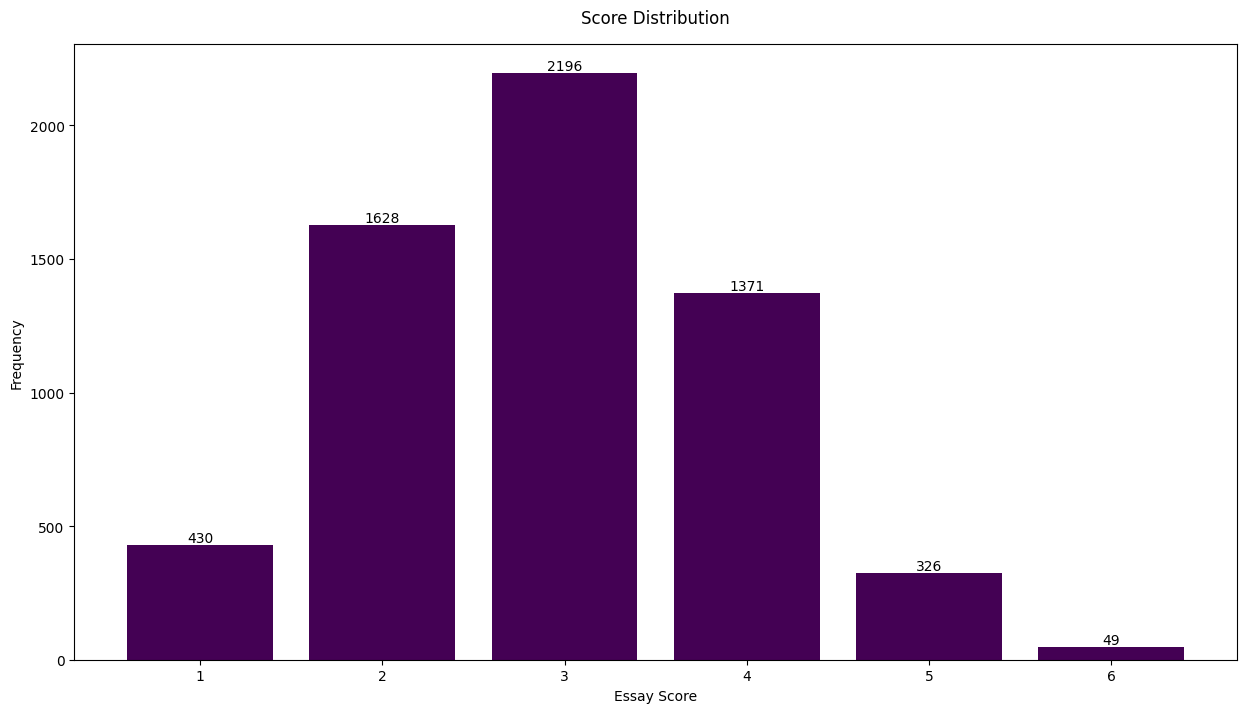

In [45]:
def essay_score_dist(essay_df):
    """
    Create a bar plot displaying the frequency of each score in the dataset.

    Parameters:
    essay_df (DataFrame): DataFrame containing essay scores.

    Returns:
    None: Displays a matplotlib bar plot.
    """
    # Create a Counter of scores from the available data
    score_bins = Counter(essay_df['score'])

    # Define all bins to display
    all_bins = [1, 2, 3, 4, 5, 6]

    # Create counts for all bins, filling missing bins with zero counts
    counts_per_bin = {bins: score_bins.get(bins, 0) for bins in all_bins}

    # Plot the count of different scores
    plt.figure(figsize=(15, 8))
    bars = plt.bar(counts_per_bin.keys(), counts_per_bin.values(), color='#440154')

    plt.ylabel('Frequency')
    plt.xlabel('Essay Score')
    plt.title('Score Distribution', y=1.02)

    # Show the counts on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, int(yval), ha='center', va='bottom')

    plt.show()

# View dataframe
essay_score_dist(essay_df)

#### Section Summary
This essay score distribution approximates a standard bell curve, with the majority of scores clustered around 1, 2, and 3. Notably, the score of 3 is the most frequently assigned in this skewed distribution. This prevalence increases the likelihood of the models assigning a score of 3, even when the input data is imperfect. Consequently, the probability of the models correctly assigning a score increases. However, it also raises the potential for the models to incorrectly learn and overfit to the score of 3, potentially compromising the accuracy of score assignments for essays that warrant different scores.

# Experiment Sections
Tokenizing step used in multiple expeiments.

In [46]:
# Tokenize the essays by applying preprocessing and then join tokens back to a single string
essay_df['preprocessed'] = essay_df['full_text'].apply(preprocess) # Apply preprocessing to each essay
essay_df['preprocessed_str'] = essay_df['preprocessed'].apply(lambda x: ' '.join(x)) # Convert list of words back to string

# Normalize scores
def min_max_normalization(score):
  """
    Normalize the score to a range between 0 and 1.

    Parameters:
    score (int): The original score of the essay.

    Returns:
    float: Normalized score.
    """
  return (score - 1) / (6-1)

essay_df['normalized_score'] = essay_df.apply(lambda row: min_max_normalization(row['score']), axis=1)

# Print the first few rows of the DataFrame
essay_df.head()

,essay_id,full_text,score,preprocessed,preprocessed_str,normalized_score
0,000d118,Many people have car where they live. The thin...,3,"[many, people, car, live, thing, know, use, ca...",many people car live thing know use car alot t...,0.4
1,000fe60,I am a scientist at NASA that is discussing th...,3,"[scientist, nasa, discussing, face, mars, expl...",scientist nasa discussing face mars explaining...,0.4
2,001ab80,People always wish they had the same technolog...,4,"[people, always, wish, technology, seen, movie...",people always wish technology seen movies best...,0.6
3,001bdc0,"We all heard about Venus, the planet without a...",4,"[heard, venus, planet, without, almost, oxygen...",heard venus planet without almost oxygen earth...,0.6
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,"[dear, state, senator, letter, argue, favor, k...",dear state senator letter argue favor keeping ...,0.4


## Experiment 1: TF-IDF Vector with Neural Net Model

Experiment 1 involves a basic approach using the TF-IDF vectorization combined with a neural network model. This represents a foundational, straightforward model utilizing default parameters, which should be effective in predicting essay grades.

#### Model Preparation

In [47]:
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=768)  # Adjust max_features as needed

# Fit and transform the text data
X = tfidf_vectorizer.fit_transform(essay_df['preprocessed_str']).toarray()

In [48]:
# Set the seed for reproducibility
np.random.seed(42)

# Generate 5 random indices for data inspection
random_indices = np.random.choice(essay_df.index, size=1, replace=False) #change size to output as many essays as needed

# Print the full text and preprocessed text for each random row
# verify processing
for index in random_indices:
  print("Row Index:", index)
  print("Full Text:")
  print(essay_df.loc[index, 'full_text'])
  print("\nPreprocessed Text:")
  print(essay_df.loc[index, 'preprocessed'])
  print("\n" + "="*50 + "\n") # add a separator between rows for readability

Row Index: 1782
Full Text:
Car alarms, car horns, and engines are basically the only thing people hear nowadays. The number of cars in the streets are simply begining to get out of hand.

Citizens all around the world, we all should really try to limit the amount of time that we are spending using our vehicals.

If you really take a moment to think about it, this could honestly turn out to be a really good thing.

Cars are not neccisarily a need, they are a want. I can undertand if you are going to be traveling a far distance that two feet cant get you, but certianlty and ten minute walk to the grocery store/market cant hurt.

Limiting car usage is very important. Most families tend to spend about about $20-50.00 on gas a week. One advantage to limiting car usuage is saving a ton of money on gas that could easily be spent of food, to feed your family.

" "

When I had a car I was always tense. I'm much happier this way" " People who have decided to limit the amount of time they spent u

<div style="display: inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1PHKM3Ik2yCg-Y8_IdtzeFPwO3qdiCU0T" width="40"/>
<font color='#3B528BFF'> <i>This step ensures the preprocessing is effective by visually comparing the original and the processed texts, which should reflect the expected transformation into a list of cleaned, lowercased strings, without numerical values and special characters.</i></font> </div>


In [49]:
# Prepare target labels
y = essay_df['score'].values

# One-hot encode the target labels
# The probability predictions need a map to the essay grade/score otherwise the
# neural net output is undetermined and doesn't make sense. This is needed for
# compatibility with the neural net.

# categorical data (score/grade)
## One-hot encode the target labels to map probability predictions to the essay grade/score
# Step 1: Convert grade to integer labels
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y)

# Step 2: Reshape the data to be a 2D array as required by OneHotEncoder
integer_encoded = integer_encoded.reshape(-1, 1)

# Step 3: Apply OneHotEncoder to transform the integer encoded labels to one-hot encoded labels
onehot_encoder = OneHotEncoder(sparse=False)
y_one_hot_encoded = onehot_encoder.fit_transform(integer_encoded)

# Print the results
print("Original Categories:", y)
print("Integer Encoded:", integer_encoded.ravel())
print("One-Hot Encoded:\n", y_one_hot_encoded)
#.unique

# Split the data into training and testing sets, ensuring an 80-20 split with a fixed random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot_encoded, test_size=0.2, random_state=42)

Original Categories: [3 3 4 ... 4 4 4]
Integer Encoded: [2 2 3 ... 3 3 3]
One-Hot Encoded:
 [[0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 ...
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [50]:
# Build and compile the multiclass classification model
input_dim = X_train.shape[1] #number of features
#dimensionality of the vectors is specified [1] chooses which feature in the set


#Number of classes
num_classes = y_one_hot_encoded.shape[1] #number of classes


# Build and compile a simple Keras model for multiclass classification
#like specifying how each split decision is made in a decision tree
inputs = Input(shape=(input_dim,)) #input layer; shape 768 dimensions; setting up an empty framework
x = Dense(128, activation='relu')(inputs) # x=hidden layer; each input gets an additional hidden layer added to the previous group
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)  # Softmax activation for multiclass classification


model = Model(inputs=inputs, outputs=outputs)

#multiclass
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 768)]             0         
                                                                 
 dense_10 (Dense)            (None, 128)               98432     
                                                                 
 dropout_44 (Dropout)        (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 64)                8256      
                                                                 
 dropout_45 (Dropout)        (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 6)                 390       
                                                                 
Total params: 107,078
Trainable params: 107,078
Non-trainab

#### Model Training

In [51]:
# step 4: Build and Train the Neural Network
# Train the Keras model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Predictions on training and test data
#predictions are probabilities of which class (grade) the essay will be placed in
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

#print (y_train_pred) #to view the output data
#print (y_test_pred)  #to view the output data




In [52]:
# Convert probabilities to class predictions
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

print(y_train_pred_classes)
print(y_test_pred_classes)
print(y)
print(y_one_hot_encoded)

[2 2 1 ... 2 1 1]
[2 2 0 ... 3 0 1]
[3 3 4 ... 4 4 4]
[[0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 ...
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]


In [53]:
# Convert integer labels to original categories
predicted_categories_train = label_encoder.inverse_transform(y_train_pred_classes)
predicted_categories_test = label_encoder.inverse_transform(y_test_pred_classes)
print(predicted_categories_train)
print(predicted_categories_test)

[3 3 2 ... 3 2 2]
[3 3 1 ... 4 1 2]


In [54]:
# Calculate accuracy
train_accuracy = accuracy_score(np.argmax(y_train, axis=1), y_train_pred_classes)
test_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_test_pred_classes)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)


Train Accuracy: 0.8829166666666667
Test Accuracy: 0.4275


<div style="display: inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1PHKM3Ik2yCg-Y8_IdtzeFPwO3qdiCU0T" width="40"/>
<font color='#3B528BFF'> <i>These results establish a solid baseline for model performance. The accuracy scores serve as a benchmark for comparing subsequent, more complex modeling approaches.</i></font> </div>

#### Final Evaluation

38/38 [==============================] - 0s 3ms/step - loss: 2.8953 - accuracy: 0.4275
Test Loss: 2.8953473567962646
Test Accuracy: 0.42750000953674316


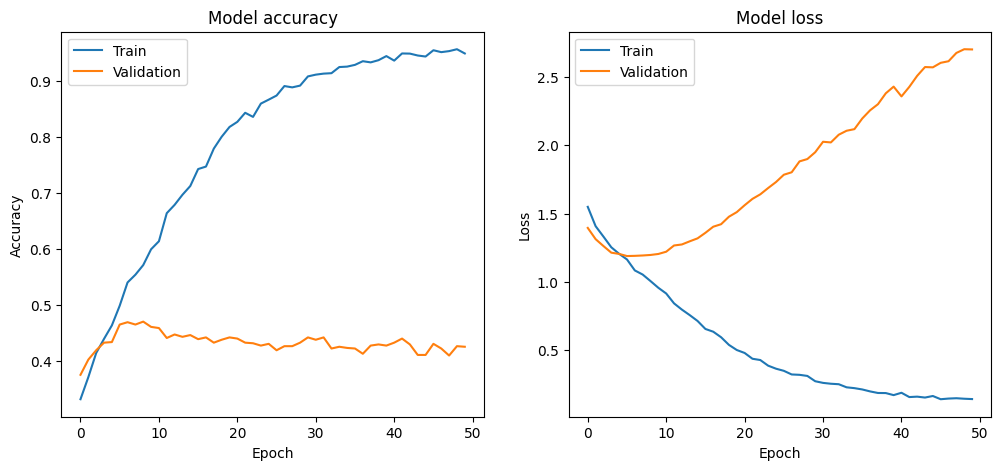

In [55]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Plot the training and validation accuracy/loss over epochs
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


#### Section Summary
The observed data indicates inconsistency in model performance. Despite the accuracy graph not reaching high values, the loss graph demonstrates an optimal point with a minimal value. To address this, adding more layers and nodes may potentially enhance the model's performance.

An increasing loss over epochs without corresponding improvements in accuracy suggests the model may be overfitting. However, there is a segment of the loss curve with a downward trend, indicating potential for improvement. Exploring ways to extend this downward trend could help refine the model's effectiveness and reduce overfitting.

## Experiment 2: TF-IDF Vector with K-Means Model

This model is designed to effectively predict clustering categories related to essay content, rather than directly assessing the grades of the essays.

#### Model Preparation

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


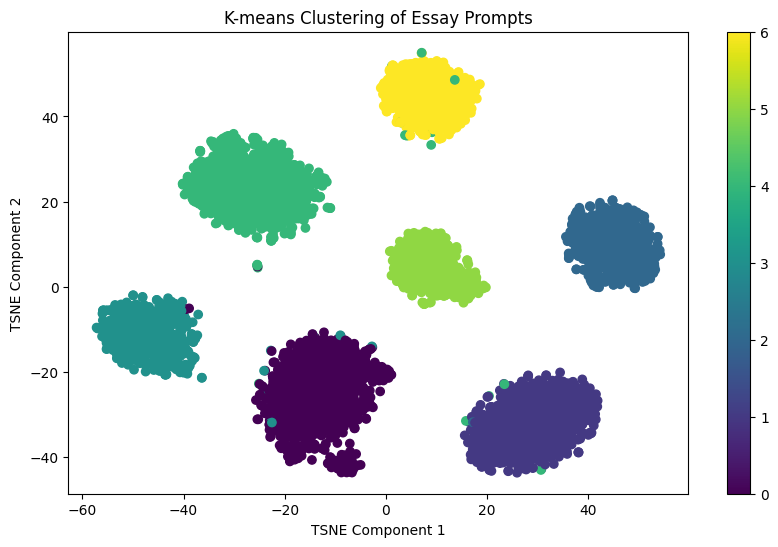

In [56]:
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=768)  # Adjust max_features as needed

# Fit and transform the text data to TF-IDF features
X = tfidf_vectorizer.fit_transform(essay_df['preprocessed_str']).toarray()

# Apply k-means clustering
num_clusters = 7 #specify the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
essay_df['cluster'] = kmeans.fit_predict(X)

# Visualize the clusters using tsne for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=essay_df['cluster'], cmap='viridis')
plt.colorbar(scatter)
plt.title('K-means Clustering of Essay Prompts')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.show()


<div style="display: inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1PHKM3Ik2yCg-Y8_IdtzeFPwO3qdiCU0T" width="40"/>
<font color='#3B528BFF'> <i>In the visualization of the clustered essay assignments, some inconsistencies, referred to as 'noise', are observed which might explain a few instances of misclassification. Since the visualization involves reducing the dimensionality of vector data through techniques like t-SNE, certain artifacts might emerge that potentially influence the accuracy of the clustering. Notably, the visualization reveals a purple cluster that appears to be bifurcated into two closely situated subclusters. This phenomenon might suggest the essays within this cluster address a topic that inherently presents a dichotomy, such as an issue with distinct 'agree' or 'disagree' positions, thereby causing a natural division within the cluster.</i></font> </div>


<div style="display: inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1PHKM3Ik2yCg-Y8_IdtzeFPwO3qdiCU0T" width="40"/>
<font color='#3B528BFF'> <i>The max_features parameter represents the upper limit of words considered in the corpus, focusing on the most impactful terms. Systematic optimization for determining this parameter could be explored further. Additionally, clustering by essay prompts has been empirically set to 7 from an initial 5 clusters. Future work might involve more systematic methods to optimize the number of clusters for better model performance.</i></font> </div>



In [57]:
def generate_word_cloud(text, num_cluster):
    """
    Generates and displays a word cloud for a given text and cluster number.

    Args:
        text (str): The input text to generate the word cloud from.
        num_cluster (int): The cluster number for which the word cloud is generated.

    Returns:
        None
    """
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Topic: {}'.format(num_cluster +1))
    plt.show()

def generate_bar_plot(text, num_cluster):
    """
    Generates and displays a bar plot of the top 5 most common words in a given text and cluster number.

    Args:
        text (str): The input text to generate the bar plot from.
        num_cluster (int): The cluster number for which the bar plot is generated.

    Returns:
        None
    """
    # Preprocess the text to remove non-alphabetic characters and convert to lower case
    words = re.findall(r'\b\w+\b', text.lower())

    # Count the frequency of each word
    word_counts = Counter(words)

    # Get the 5 most common words and their frequencies
    most_common_words = word_counts.most_common(5)

    # Separate the words and their frequencies for plotting
    words, frequencies = zip(*most_common_words)

    # Get colors from colormap
    #colors = [cmap(i / len(words)) for i in range(len(words))]

    # Get colors from colormap
    colors = cmap(num_cluster/6)

    # Create the bar plot
    plt.figure(figsize=(10, 5))
    bars = plt.bar(words, frequencies, color=colors)

    # Add title and labels
    plt.title('Top 5 Words in Topic: {}'.format(num_cluster +1), fontsize=15)
    plt.xlabel('Words', labelpad=15, fontsize=15)
    plt.ylabel('Frequency', labelpad=15, fontsize=15)

    # Show the counts on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, int(yval), ha='center', va='bottom')

    # Display the plot
    plt.show()

<div style="display: inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1PHKM3Ik2yCg-Y8_IdtzeFPwO3qdiCU0T" width="40"/>
<font color='#3B528BFF'> <i>The previous functions generate visualizations to analyze the content of clustered essay assignments. The generate_word_cloud function creates a word cloud to visually represent the most frequent words in a given cluster. The generate_bar_plot function generates a bar plot to display the top five most common words and their frequencies within a cluster. These visualizations help identify predominant topics and terms in each cluster.</i></font> </div>


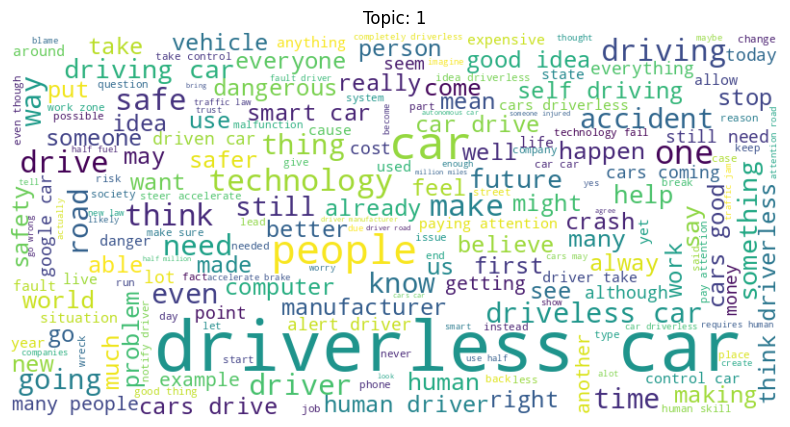

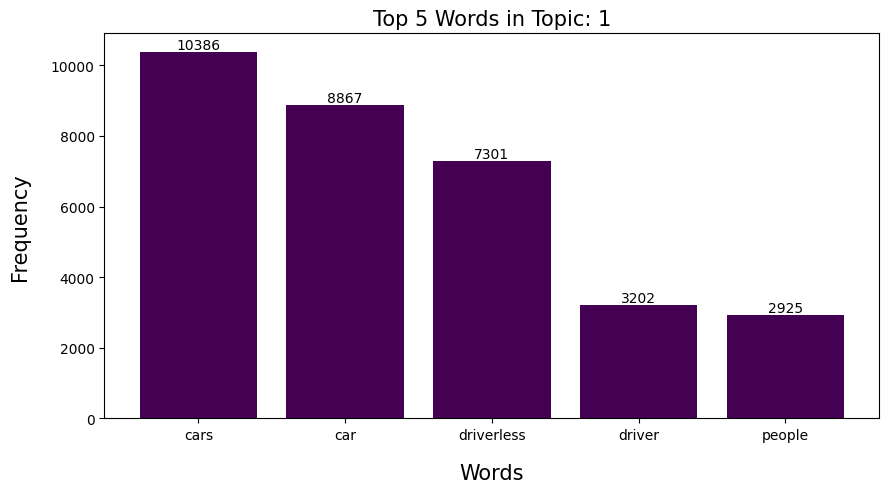

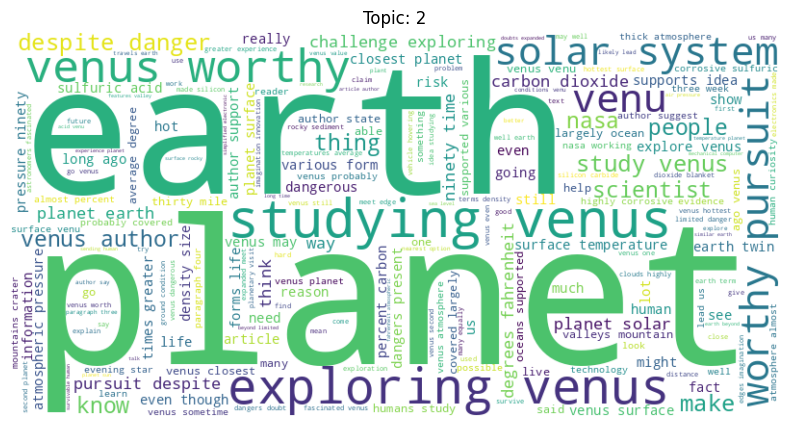

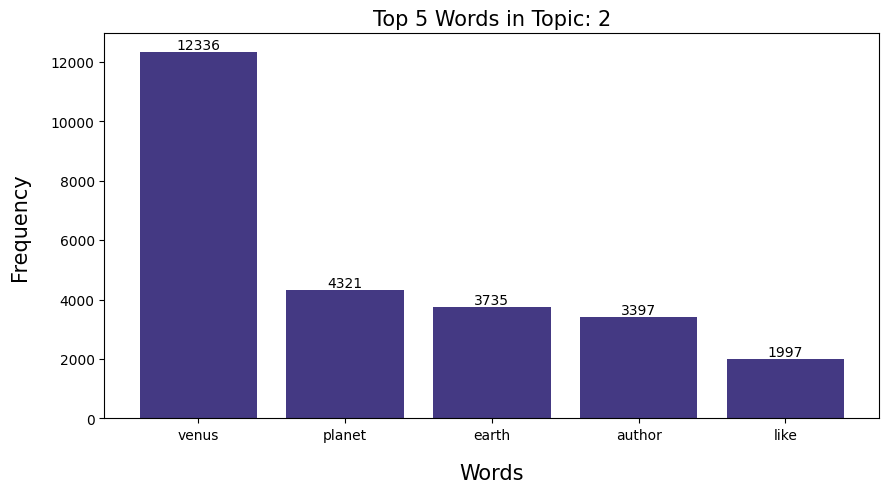

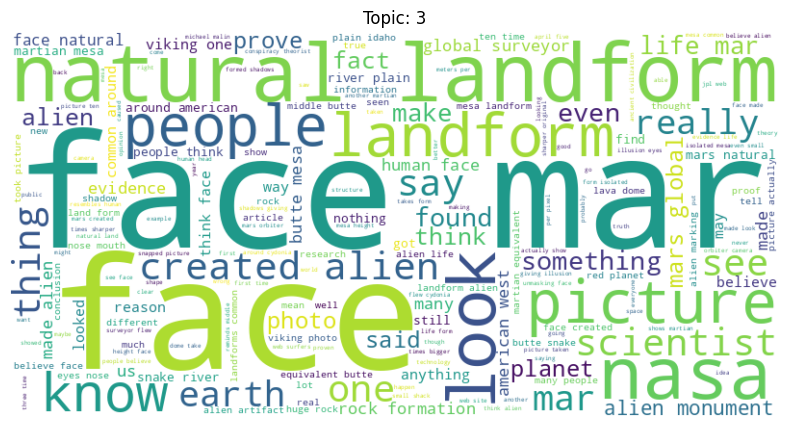

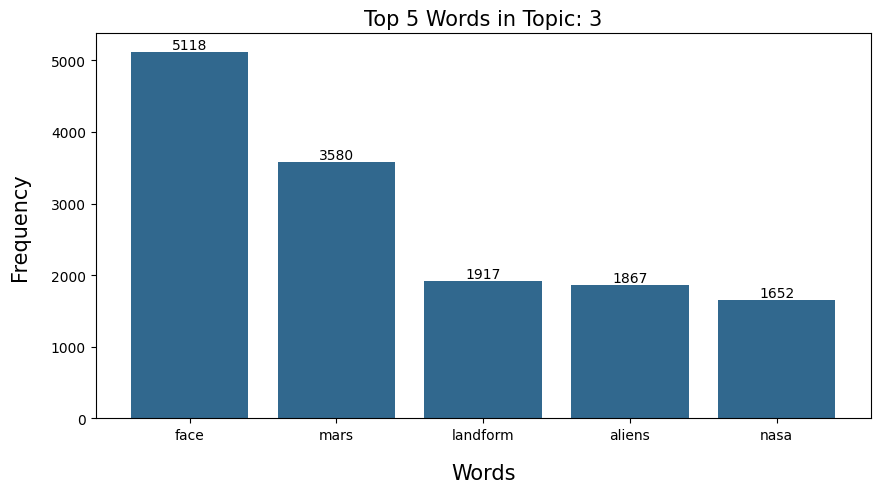

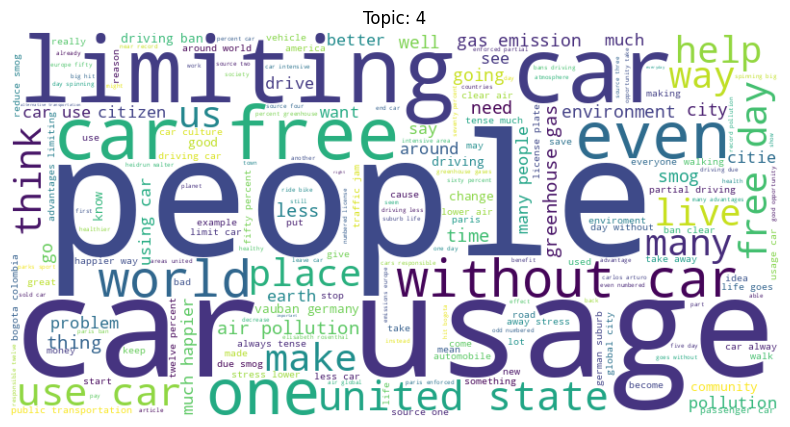

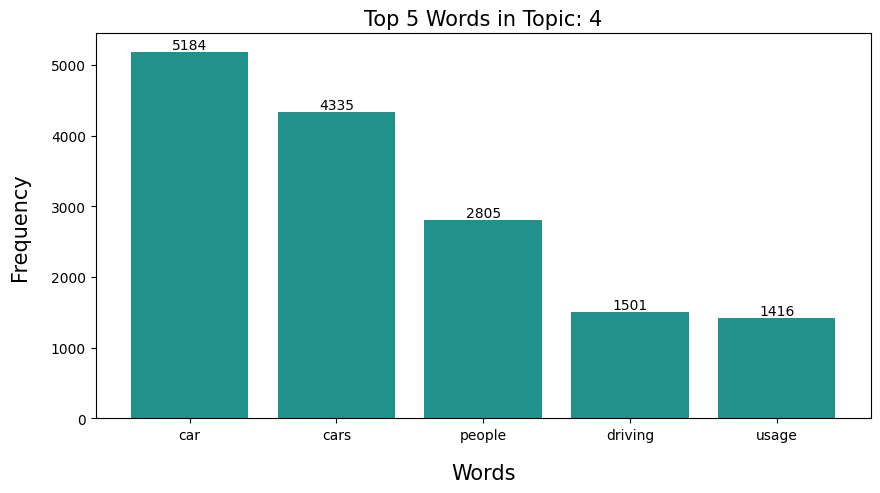

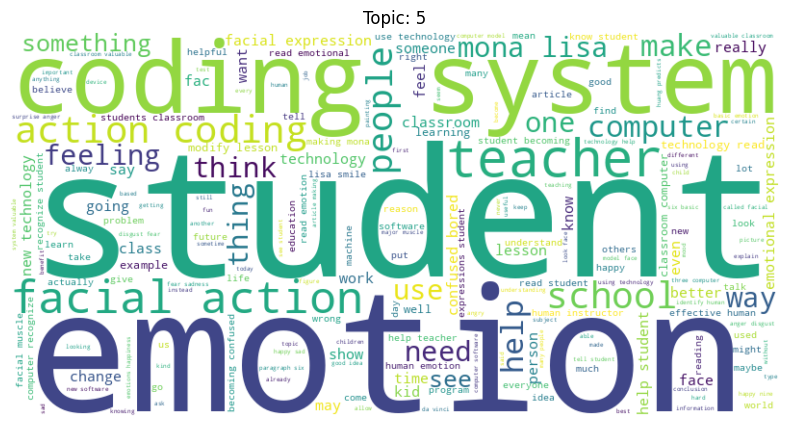

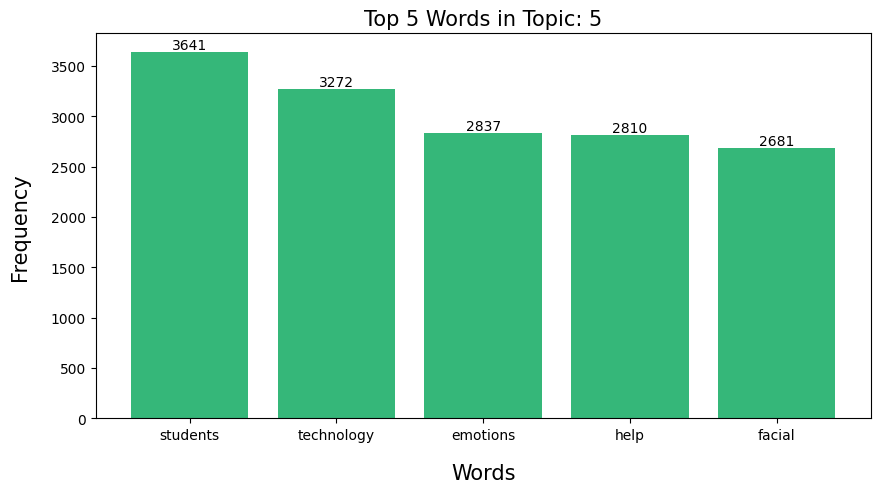

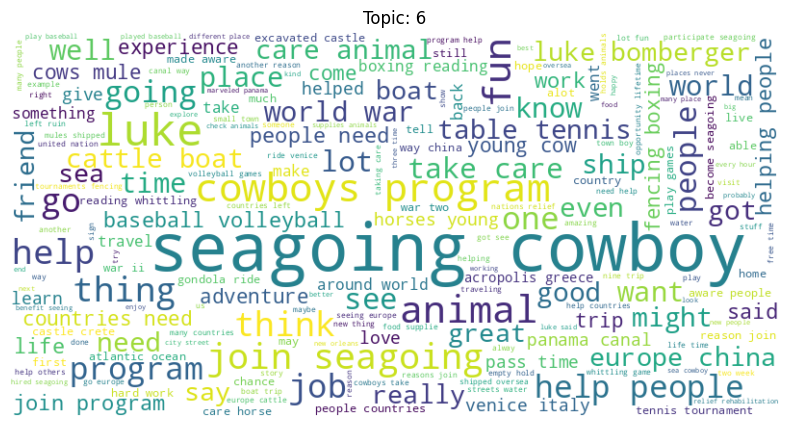

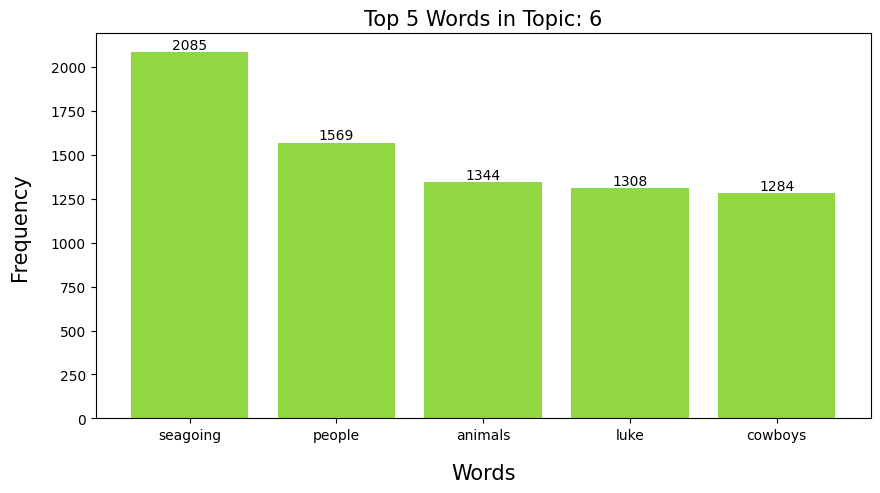

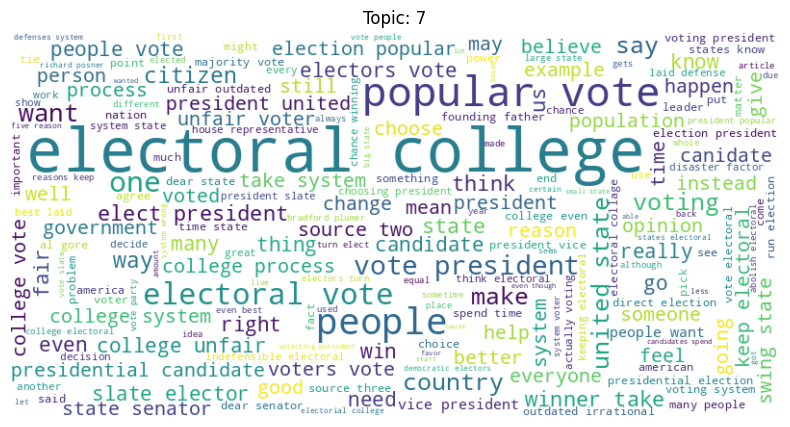

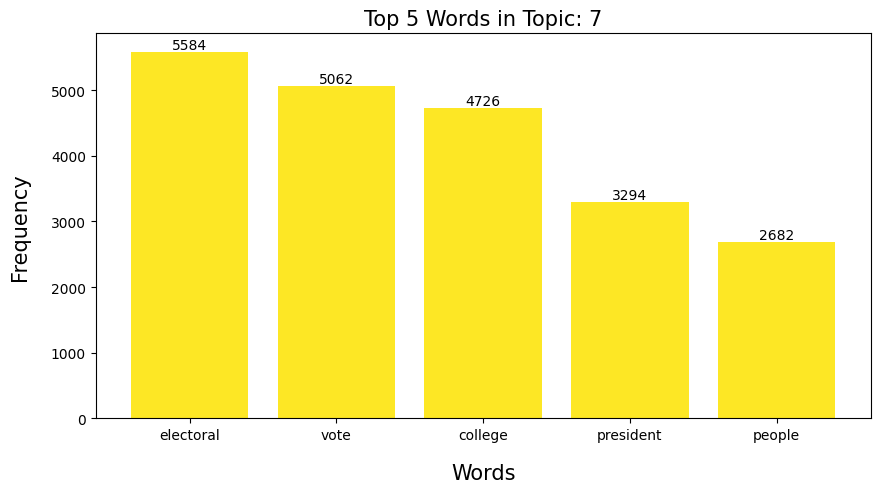

In [58]:
essay_df['cluster']

for i in range (num_clusters):
 cluster_lists = ' '.join(essay_df[essay_df['cluster'] == i]['preprocessed_str'])
# Generate and display the word cloud
 generate_word_cloud(cluster_lists, i)
# Generate a ranked bar plot of words
 generate_bar_plot(cluster_lists, i)


<div style="display: inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1PHKM3Ik2yCg-Y8_IdtzeFPwO3qdiCU0T" width="40"/>
<font color='#3B528BFF'> <i>The bar charts revealed the most probable essay question topic prompts based on term frequency. These are as follows:
<br>
<br>
<font color='#3B528BFF'><strong>
Topic 1:</strong> This essay prompt might ask students to discuss the impact of driverless cars on society.
<br>
<font color='#3B528BFF'><strong>
Topic 2:</strong> This essay prompt could be a comparative analysis of Venus and Earth.
<br>
<font color='#3B528BFF'><strong>
Topic 3:</strong> This essay prompt could be asking students to analyze different aspects of Mars exploration.
<br>
<font color='#3B528BFF'><strong>
Topic 4:</strong> This essay prompt could ask students to consider the impact of car usage on society and the environment.
<br>
<font color='#3B528BFF'><strong>
Topic 5:</strong> This essay prompt may be asking about the role of technology in helping students manage emotions.
<br>
<font color='#3B528BFF'><strong>
Topic 6:</strong> This essay prompt may ask students to analyze the interplay of seagoing adventures and western cowboy culture in literature and media.
<br>
<font color='#3B528BFF'><strong>
Topic 7:</strong> This essay topic perhaps asks students to explore the Electoral College and its impact on presidential elections.

<br>
<br>
<div style="display: inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1PHKM3Ik2yCg-Y8_IdtzeFPwO3qdiCU0T" width="40"/>
Now, at this stage, it is smart to spot-check the data that will be utilized for neural network training. This involves verifying the preprocessing steps by comparing the full text of the essays with their preprocessed versions. The goal is to ensure that the preprocessing has been performed correctly and the preprocessed text is a list of strings, as expected.</i></font> </div>


In [59]:
# Set the seed for reproducibility
np.random.seed(42)

# Generate 5 random indices for data inspection
random_indices = np.random.choice(essay_df.index, size=1, replace=False) #change size to output as many essays as needed

# Print the full text and preprocessed text for each randomly selected essay
for index in random_indices:
    print("Row Index:", index) # Print the index of the essay
    print("Full Text:") # Print the label for the full text
    print(essay_df.loc[index, 'full_text']) # Print the full text of the essay
    print("\nPreprocessed Text:") # Print the label for the preprocessed text
    print(essay_df.loc[index, 'preprocessed']) # Print the preprocessed text of the essay
    print("\nTopic:", essay_df.loc[index, 'cluster'])
    print("\n" + "=" * 50 + "\n")  # add a separator between rows


Row Index: 1782
Full Text:
Car alarms, car horns, and engines are basically the only thing people hear nowadays. The number of cars in the streets are simply begining to get out of hand.

Citizens all around the world, we all should really try to limit the amount of time that we are spending using our vehicals.

If you really take a moment to think about it, this could honestly turn out to be a really good thing.

Cars are not neccisarily a need, they are a want. I can undertand if you are going to be traveling a far distance that two feet cant get you, but certianlty and ten minute walk to the grocery store/market cant hurt.

Limiting car usage is very important. Most families tend to spend about about $20-50.00 on gas a week. One advantage to limiting car usuage is saving a ton of money on gas that could easily be spent of food, to feed your family.

" "

When I had a car I was always tense. I'm much happier this way" " People who have decided to limit the amount of time they spent u

<div style="display: inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1PHKM3Ik2yCg-Y8_IdtzeFPwO3qdiCU0T" width="40"/>
<font color='#3B528BFF'> <i>One-hot encoding the target labels is necessary because the output is categorical. Probability predictions require a mapping to the essay grade/score; otherwise, the neural network output is ambiguous and can lead to incorrect data.</i></font> </div>

In [60]:
# Prepare target labels
y = essay_df['score'].values

# categorical data (score/grade)
## One-hot encode the target labels to map probability predictions to the essay grade/score
# Step 1: Convert grade to integer labels
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y)

# Step 2: Reshape the data to be a 2D array as required by OneHotEncoder
integer_encoded = integer_encoded.reshape(-1, 1)

# Step 3: Apply OneHotEncoder to transform the integer encoded labels to one-hot encoded labels
onehot_encoder = OneHotEncoder(sparse=False)
y_one_hot_encoded = onehot_encoder.fit_transform(integer_encoded)

# Print the results
print("Original Categories:", y)
print("Integer Encoded:", integer_encoded.ravel())
print("One-Hot Encoded:\n", y_one_hot_encoded)
#.unique

# Split the data into training and testing sets, ensuring an 80-20 split with a fixed random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot_encoded, test_size=0.2, random_state=42)

Original Categories: [3 3 4 ... 4 4 4]
Integer Encoded: [2 2 3 ... 3 3 3]
One-Hot Encoded:
 [[0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 ...
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


<div style="display: inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1PHKM3Ik2yCg-Y8_IdtzeFPwO3qdiCU0T" width="40"/>
<font color='#3B528BFF'> <i>Keras Tuner's RandomSearch (explores different hyperparameters randomly until it finds the optimal set, which is useful because doesn't get stcuk in local minimums where other algorithms can), BayesianOptimization (seeks the best parameters similar to gradient descent), and Hyperband are search methods to find the optimal hyperparameters.
<br>
When determining the optimal hyperparameters for a neural network, consider the impact of the number of hidden layers, the number of units in each layer, the dropout rates, and the optimizer used. These hyperparameters can significantly influence the model's performance, including its ability to generalize without overfitting or underfitting.
<br>
<br>
<strong>This notebook uses the following approach to accomplish this:
</strong><br>
1. Extraction: Extract the number of layers, units per layer, dropout rates per layer, and the optimizer used from the best hyperparameters.
<br>
2. Informative Print Statements: Provide insights into the optimal architecture found by the tuner.
<br>
3. Retraining: Retrains the model with the best hyperparameters to see the final performance, which is useful for verification purposes.
<br>
<br>
<div style="display: inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1PHKM3Ik2yCg-Y8_IdtzeFPwO3qdiCU0T" width="40"/>This neural network model fine-tunes the number of layers based on the best hyperparameters determined from Bayesian optimization.</i></font> </div>

In [61]:
# Number of classes
num_classes = y_one_hot_encoded.shape[1]  # number of classes

def build_model(hp):
    """
    Build and compile a Keras model with hyperparameters.

    Parameters:
    hp : keras_tuner.HyperParameters
        Hyperparameters object for tuning.

    Returns:
    model : tensorflow.keras.Model
        Compiled Keras model.
    """
    model = Sequential()
    # Input layer with variable units
    model.add(Dense(units=hp.Int('units_input', min_value=32, max_value=1024, step=16),
                    activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(hp.Float('dropout_input', min_value=0.2, max_value=0.5, step=0.1)))

    # Variable number of hidden layers
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=1024, step=16),
                        activation='relu'))
        model.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.2, max_value=0.5, step=0.1)))

    # Output layer with softmax activation for multiclass classification
    model.add(Dense(num_classes, activation='softmax'))

    # Compile model with selected optimizer
    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd']),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Using Bayesian Optimization for hyperparameter tuning
tuner = kt.BayesianOptimization(
    hypermodel=build_model,
    objective='val_accuracy',
    max_trials=10,
    num_initial_points=None,
    alpha=0.0001,
    beta=2.6,
    seed=42,
    hyperparameters=None,
    tune_new_entries=True,
    allow_new_entries=True,
    max_retries_per_trial=0,
    max_consecutive_failed_trials=3
)

# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Gather details about the best hyperparameters
num_layers = best_hps.get('num_layers')
layer_units = [best_hps.get(f'units_{i}') for i in range(num_layers)]
dropout_rates = [best_hps.get(f'dropout_{i}') for i in range(num_layers)]
optimizer = best_hps.get('optimizer')

print(f"""
The hyperparameter search is complete. The optimal hyperparameters are:
- Units in the input layer: {best_hps.get('units_input')}
- Number of hidden layers: {num_layers}
- Dropout rate for input layer: {best_hps.get('dropout_input')}
- Optimizer: {optimizer}
""")

for i in range(num_layers):
    print(f"""
    Hidden Layer {i + 1}:
    - Units: {layer_units[i]}
    - Dropout rate: {dropout_rates[i]}
    """)
# step 4: Build the model with the best hyperparameters and train it
# Retrain the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32, validation_split=0.2, verbose=0)


Reloading Tuner from ./untitled_project/tuner0.json

The hyperparameter search is complete. The optimal hyperparameters are:
- Units in the input layer: 576
- Number of hidden layers: 2
- Dropout rate for input layer: 0.2
- Optimizer: rmsprop


    Hidden Layer 1:
    - Units: 272
    - Dropout rate: 0.4
    

    Hidden Layer 2:
    - Units: 944
    - Dropout rate: 0.2
    


#### Model Training


In [62]:
# Calculate accuracy
train_accuracy = model.evaluate(X_train, y_train)
print(f'Train Accuracy: {train_accuracy}')
test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')

150/150 [==============================] - 1s 5ms/step - loss: 2.5803 - accuracy: 0.8825
Train Accuracy: [2.5803444385528564, 0.8824999928474426]
38/38 [==============================] - 0s 5ms/step - loss: 14.6321 - accuracy: 0.4050
Test Accuracy: [14.632088661193848, 0.4050000011920929]


<div style="display: inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1PHKM3Ik2yCg-Y8_IdtzeFPwO3qdiCU0T" width="40"/>
<font color='#3B528BFF'> <i>The training accuracy score is significantly higher than the testing accuracy score, indicating that the model is overfitting. This means the model is memorizing the training data rather than generalizing well to unseen data.
<br>
<br><strong>
Several strategies could potentially reduce overfitting:
</strong><br>
1. Tweaking the model parameters (reducing the number of epochs, adjusting the optimizer, etc.).
<br>
2. Experimenting with adding more layers or increasing the dimensions might help mitigate overfitting.
<br>
3. Utilizing deeper learning architectures with potentially hundreds of layers could be explored.</i></font> </div>


#### Final Evaluation

38/38 [==============================] - 0s 5ms/step - loss: 14.6321 - accuracy: 0.4050
Test Loss: 14.632088661193848
Test Accuracy: 0.4050000011920929


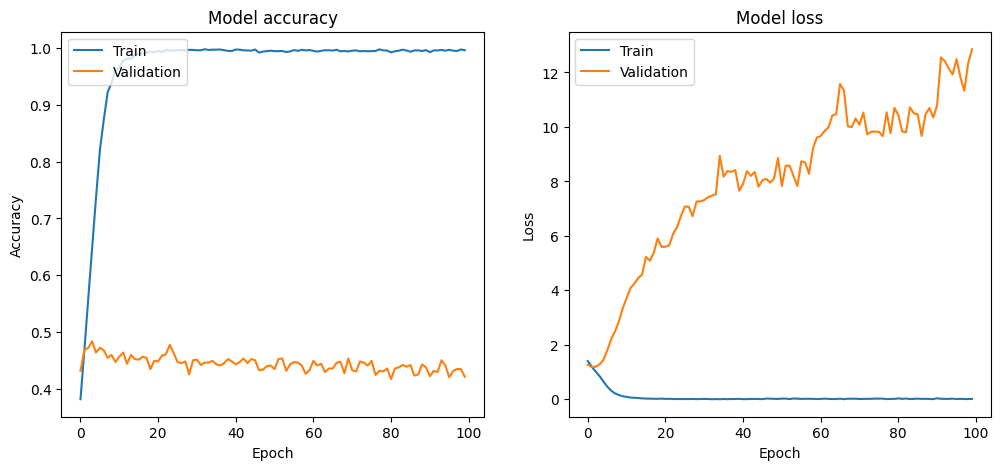

In [63]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Plot the training and validation accuracy/loss over epochs
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

#### Section Summary
These graphs are the main take away of the training process. The validation scores are pretty flat. That correlates with the increase in validation on loss graph basically saying that the training isn't making it any better and so the 'loss' of resources continues to increase.

A potential improvement could be to attepmt a different vectorization technique that could encode more information from each essay.


Test Accuracy = Validation


## Experiment 3: BERT Vector and Model

This model should improve grade prediction accuracy compared to previous models. High accuracy scores can be challenging to achieve but this experiment will nevertheless serve as a good comparison between models. Given the complexity of the data, BERT is expected to provide better vector representations than TF-IDF. The comparison between these vectorizers will help us understand their effectiveness.


#### Model Preparation

<div style="display: inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1PHKM3Ik2yCg-Y8_IdtzeFPwO3qdiCU0T" width="40"/>
<font color='#3B528BFF'> <i>Here a Bert Tokenizer is used. The Bert (Bidirectional Encoder Representations from Transformers) is a pre-trained transformer-based model for natural language understanding tasks, trained on large amounts of text data.
<br>
<br>
Transformer-based models (like BERT), can capture intricate nuances in language usage, context, and semantics. BERT excels in understanding the relationships between different parts of the text and can provide nuanced assessments aligned with the criteria of the rubric. Additionally, the bidirectional nature allows BERT to consider the entire context of the essay when making scoring decisions.</i></font> </div>


In [64]:
# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

def bert_vectorizer(text):
    """
    Vectorizes input text using BERT model.

    Parameters:
    text : str
        The input text to be vectorized.

    Returns:
    np.ndarray
        The BERT vector representation of the input text.
    """
    inputs = tokenizer(text, return_tensors='tf', truncation=True, padding=True)
    outputs = bert_model(inputs)
    return tf.reduce_mean(outputs.last_hidden_state, axis=1).numpy().squeeze()



Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


<div style="display: inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1PHKM3Ik2yCg-Y8_IdtzeFPwO3qdiCU0T" width="40"/>
<font color='#3B528BFF'> <i>The above message is informational and does not indicate an error. Since I will be fine-tuning, I'll ignore and continue.</i></font> </div>



In [65]:
# just the first 2000 rows from the data: due to size of RAM needed
#this is where the shared and BERT data frame split
essay_df_BERT = essay_df.iloc[:2000]

# Apply BERT vectorization to the DataFrame
essay_df_BERT['bert_embeddings'] = essay_df_BERT['preprocessed_str'].apply(bert_vectorizer)


<ipython-input-65-837411ab93d9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  essay_df_BERT['bert_embeddings'] = essay_df_BERT['preprocessed_str'].apply(bert_vectorizer)


In [66]:
# View data frame
essay_df.head()

,essay_id,full_text,score,preprocessed,preprocessed_str,normalized_score,cluster
0,000d118,Many people have car where they live. The thin...,3,"[many, people, car, live, thing, know, use, ca...",many people car live thing know use car alot t...,0.4,3
1,000fe60,I am a scientist at NASA that is discussing th...,3,"[scientist, nasa, discussing, face, mars, expl...",scientist nasa discussing face mars explaining...,0.4,2
2,001ab80,People always wish they had the same technolog...,4,"[people, always, wish, technology, seen, movie...",people always wish technology seen movies best...,0.6,0
3,001bdc0,"We all heard about Venus, the planet without a...",4,"[heard, venus, planet, without, almost, oxygen...",heard venus planet without almost oxygen earth...,0.6,1
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,"[dear, state, senator, letter, argue, favor, k...",dear state senator letter argue favor keeping ...,0.4,6


<div style="display: inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1PHKM3Ik2yCg-Y8_IdtzeFPwO3qdiCU0T" width="40"/>
<font color='#3B528BFF'> <i>Code check, the verification of the BERT embedding for the first essay will be performed. The preprocessing output will be compared with the BERT embedding data to ensure they meet the expected criteria. Specifically, the BERT output dimensions will be checked to confirm they are 768-dimensional vectors, as anticipated.</i></font> </div>


In [67]:
# Print the full content of the 'bert_embeddings' column for the first row
bert_embeddings = essay_df_BERT.loc[0, 'bert_embeddings']
#print(bert_embeddings) #this code can be uncommented to check the BERT encodings
print(len(bert_embeddings))

768


<div style="display: inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1PHKM3Ik2yCg-Y8_IdtzeFPwO3qdiCU0T" width="40"/>
<font color='#3B528BFF'> <i>looks good - one vector with 768 dimensions. This is what the function was expected to output.</i></font> </div>

In [68]:
# Set the seed for reproducibility
np.random.seed(42)

# Generate 5 random indices for data inspection
random_indices = np.random.choice(essay_df_BERT.index, size=1, replace=False) #change size to output as many essays as needed

# Print the full text and preprocessed text for each randomly selected essay
for index in random_indices:
  print("Row Index:", index) # Print the index of the essay
  print("Full Text:") # Print the label for the full text
  print(essay_df_BERT.loc[index, 'full_text']) # Print the full text of the essay
  print("\nPreprocessed Text:") # Print the label for the preprocessed text
  print(essay_df_BERT.loc[index, 'preprocessed']) # Print the preprocessed text of the essay
  print("\n" + "="*50 + "\n") # add a separator between rows

Row Index: 1860
Full Text:
Many people have different opinions about what happens on the planet Mars. During a recent discovery many people had the idea that the face on mars was created by aliens. Scientists had a different theory. Scientists believed that the face was formed by something more believable. Aliens was not one of those.

On May 24th NASA's Viking 1 spacecraft was on Mars. The spacecraft was going about it's regular mission until it noticed something interesting. The text states, "..when it spotted the shadowy likenss of a human face." The text states, "A few days later NASA unveiled the image for all to see." Once NASA revealed the images for the world to see, many of them claimed it was from aliens. Scientists had to quickly do their research to clear up false accusations. The text states, "Thousands of anxious web surfers were waiting when the image first appeared on a JPL web site, revealing...a natural landform. There was no alien monument after all." Once NASA clear

<div style="display: inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1PHKM3Ik2yCg-Y8_IdtzeFPwO3qdiCU0T" width="40"/>
<font color='#3B528BFF'> <i>This verification includes a check to ensure that the preprocessing worked correctly.
The full text of the essays is compared with the preprocessed text to confirm that
the preprocessing has produced the expected list of strings.</i></font> </div>

In [69]:
# Prepare the data for Keras model
X = np.stack(essay_df_BERT['bert_embeddings'].values)
y = essay_df_BERT['score'].values

# categorical data (score/grade)
## One-hot encode the target labels to map probability predictions to the essay grade/score
# Step 1: Convert grade to integer labels
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y)

# Step 2: Reshape the data to be a 2D array as required by OneHotEncoder
integer_encoded = integer_encoded.reshape(-1, 1)

# Step 3: Apply OneHotEncoder to transform the integer encoded labels to one-hot encoded labels
onehot_encoder = OneHotEncoder(sparse=False)
y_one_hot_encoded = onehot_encoder.fit_transform(integer_encoded)

# Print the results
print("Original Categories:", y)
print("Integer Encoded:", integer_encoded.ravel())
print("One-Hot Encoded:\n", y_one_hot_encoded)
#.unique

# Split the data into training and testing sets, ensuring an 80-20 split with a fixed random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot_encoded, test_size=0.2, random_state=42)

Original Categories: [3 3 4 ... 4 2 3]
Integer Encoded: [2 2 3 ... 3 1 2]
One-Hot Encoded:
 [[0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 ...
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


<div style="display: inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1PHKM3Ik2yCg-Y8_IdtzeFPwO3qdiCU0T" width="40"/>
<font color='#3B528BFF'> <i>(summary from the documentation for future experiments)
<br>
When fine-tuning transformer-based models like BERT for essay scoring to align with a grading rubric, several hyperparameters can be adjusted to optimize performance:
<br>
<strong>1. Learning Rate:</strong> This hyperparameter controls the step size during the optimization process. It can be tuned to ensure that the model learns at an appropriate pace, effectively updating its parameters to minimize the loss function.
<br>
<strong>2. Batch Size:</strong> The batch size determines the number of samples processed in each training iteration. Adjusting this hyperparameter can impact the model's generalization ability and training speed.
<br>
<strong>3. Number of Training Epochs:</strong> The number of training epochs specifies how many times the entire training dataset is passed through the model. Fine-tuning may require experimenting with different numbers of epochs to achieve optimal performance without overfitting.
<br>
<strong>4. Dropout Rate:</strong> Dropout is a regularization technique that randomly drops a fraction of input units during training to prevent overfitting. Tuning the dropout rate can help balance model complexity and generalization.
<br>
<strong>5. Layer-specific Hyperparameters:</strong> Some transformer architectures, such as BERT, have multiple layers with their own hyperparameters, such as the number of attention heads, hidden units, and feedforward layer sizes. Fine-tuning these parameters can be beneficial for adapting the model to specific tasks and datasets.</i></font> </div>

In [70]:
# Build and compile a simple multiclass classification Keras model
input_dim = X_train.shape[1] #number of features
#dimensionality of the vectors is specified [1] chooses which feature in the set

#Number of classes
num_classes = y_one_hot_encoded.shape[1] #number of classes

# Build and compile a simple Keras model for multiclass classification
#like specificying how each split decision is made in a decision tree
inputs = Input(shape=(input_dim,)) #input layer; shape 768 dimensions; setting up an empty framework
x = Dense(128, activation='relu')(inputs) # x=hidden layer; each input gets an additional hidden layer added to the previous group
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)  # Softmax activation for multiclass classification


model = Model(inputs=inputs, outputs=outputs)

#multiclass
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#optimizer = AdamW(model.parameters(), lr=learning_rate), consider tuning these in future

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 768)]             0         
                                                                 
 dense_17 (Dense)            (None, 128)               98432     
                                                                 
 dropout_86 (Dropout)        (None, 128)               0         
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dropout_87 (Dropout)        (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 6)                 390       
                                                                 
Total params: 107,078
Trainable params: 107,078
Non-trainab

#### Model Training

<div style="display: inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1PHKM3Ik2yCg-Y8_IdtzeFPwO3qdiCU0T" width="40"/>
<font color='#3B528BFF'> <i>Predictions represent the probabilities of each class (grade) that the essay will be assigned to.</i></font> </div>


In [71]:
# step 4: Build and Train the Neural Network Model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=500, batch_size=32, validation_split=0.2, verbose=0)

# Predictions on training and test data
#predictions are probabilities of which class (grade) the essay will be placed in
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print (y_train_pred)
print (y_test_pred)



[[9.8631402e-11 1.1250685e-03 9.9886715e-01 7.8288067e-06 1.3084840e-18
  4.2103722e-26]
 [4.3958885e-06 1.7589366e-01 8.2405120e-01 5.0774321e-05 1.4199133e-12
  2.9541703e-16]
 [3.0897261e-04 1.2601645e-01 8.7367338e-01 1.2789720e-06 2.8866398e-13
  3.4049505e-15]
 ...
 [1.2410699e-15 1.7419895e-02 9.8258013e-01 5.9604365e-19 0.0000000e+00
  0.0000000e+00]
 [4.8147031e-05 9.9995100e-01 8.2143413e-07 7.9977265e-34 0.0000000e+00
  0.0000000e+00]
 [1.1812013e-11 2.0145005e-02 9.7925204e-01 6.0294732e-04 1.1321232e-16
  5.6538677e-25]]
[[9.6343907e-13 1.4817360e-01 8.5182637e-01 1.0551482e-08 2.5831085e-25
  9.0853931e-34]
 [1.7479994e-16 1.4567030e-04 9.9984825e-01 6.0265043e-06 1.4380897e-24
  9.9999017e-37]
 [3.9540868e-02 1.1121922e-02 5.9737337e-01 3.3158138e-01 1.9682411e-02
  6.9991942e-04]
 ...
 [3.8611527e-09 4.3846771e-15 2.2345166e-07 5.8048522e-01 3.7970546e-01
  3.9809112e-02]
 [3.4788195e-06 1.0262672e-01 7.4138248e-01 1.5598723e-01 4.7735792e-08
  3.6237677e-13]
 [7.190132

In [72]:
# Convert probabilities to class predictions
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

print(y_train_pred_classes)
print(y_test_pred_classes)
print(y)
print(y_one_hot_encoded)

[2 2 2 ... 2 1 2]
[2 2 2 1 1 2 1 2 1 3 1 1 1 2 2 3 1 2 3 1 0 1 2 0 1 3 1 1 1 1 2 2 2 1 1 1 1
 2 2 3 1 3 1 2 2 2 2 3 3 2 3 3 2 2 1 3 3 1 1 1 1 2 3 3 2 1 2 2 3 2 3 1 2 1
 2 1 2 2 1 2 1 4 1 2 2 2 3 1 2 1 3 3 1 2 1 1 0 1 1 2 1 2 0 1 2 2 4 2 1 2 2
 3 1 2 1 2 3 2 3 0 2 2 2 1 2 2 1 3 1 2 1 2 2 2 2 2 1 4 2 2 1 1 3 0 3 2 0 1
 2 3 0 1 1 2 3 2 3 3 2 2 1 1 0 2 2 1 3 3 2 1 1 2 3 2 3 3 2 2 3 3 4 2 3 2 4
 2 1 1 3 3 1 3 2 2 1 4 1 2 1 1 2 1 2 2 2 2 2 3 1 1 4 3 2 2 2 3 1 2 4 1 1 2
 3 1 2 1 1 1 1 3 1 3 3 3 2 3 3 2 2 2 2 3 3 2 2 2 1 2 1 2 0 2 2 3 1 2 1 2 3
 2 2 2 1 3 4 2 2 1 2 3 2 2 1 1 0 1 1 1 2 2 2 2 1 1 2 2 1 1 2 2 1 1 1 1 2 2
 3 1 2 2 0 2 1 2 1 2 2 1 3 3 3 2 3 4 3 2 1 2 2 1 1 3 1 1 3 3 1 3 1 5 3 1 2
 2 1 2 1 2 1 2 2 2 1 1 2 3 2 1 0 1 1 3 2 1 2 2 2 2 1 3 2 1 2 3 1 1 2 0 2 2
 2 1 2 1 3 1 3 1 2 2 0 1 2 1 3 1 2 2 2 1 2 1 2 1 2 1 2 3 2 3]
[3 3 4 ... 4 2 3]
[[0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 ...
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]


<div style="display: inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1PHKM3Ik2yCg-Y8_IdtzeFPwO3qdiCU0T" width="40"/>
<font color='#3B528BFF'> <i>In this code check, the correct decoding of the data is being confirmed. When the data is encoded, it's challenging to understand the exact transformations that have been applied.</i></font> </div>

In [73]:
# Convert integer labels to original categories
predicted_categories_train = label_encoder.inverse_transform(y_train_pred_classes)
predicted_categories_test = label_encoder.inverse_transform(y_test_pred_classes)
print(predicted_categories_train)
print(predicted_categories_test)

[3 3 3 ... 3 2 3]
[3 3 3 2 2 3 2 3 2 4 2 2 2 3 3 4 2 3 4 2 1 2 3 1 2 4 2 2 2 2 3 3 3 2 2 2 2
 3 3 4 2 4 2 3 3 3 3 4 4 3 4 4 3 3 2 4 4 2 2 2 2 3 4 4 3 2 3 3 4 3 4 2 3 2
 3 2 3 3 2 3 2 5 2 3 3 3 4 2 3 2 4 4 2 3 2 2 1 2 2 3 2 3 1 2 3 3 5 3 2 3 3
 4 2 3 2 3 4 3 4 1 3 3 3 2 3 3 2 4 2 3 2 3 3 3 3 3 2 5 3 3 2 2 4 1 4 3 1 2
 3 4 1 2 2 3 4 3 4 4 3 3 2 2 1 3 3 2 4 4 3 2 2 3 4 3 4 4 3 3 4 4 5 3 4 3 5
 3 2 2 4 4 2 4 3 3 2 5 2 3 2 2 3 2 3 3 3 3 3 4 2 2 5 4 3 3 3 4 2 3 5 2 2 3
 4 2 3 2 2 2 2 4 2 4 4 4 3 4 4 3 3 3 3 4 4 3 3 3 2 3 2 3 1 3 3 4 2 3 2 3 4
 3 3 3 2 4 5 3 3 2 3 4 3 3 2 2 1 2 2 2 3 3 3 3 2 2 3 3 2 2 3 3 2 2 2 2 3 3
 4 2 3 3 1 3 2 3 2 3 3 2 4 4 4 3 4 5 4 3 2 3 3 2 2 4 2 2 4 4 2 4 2 6 4 2 3
 3 2 3 2 3 2 3 3 3 2 2 3 4 3 2 1 2 2 4 3 2 3 3 3 3 2 4 3 2 3 4 2 2 3 1 3 3
 3 2 3 2 4 2 4 2 3 3 1 2 3 2 4 2 3 3 3 2 3 2 3 2 3 2 3 4 3 4]


In [74]:
# Calculate accuracy
train_accuracy = accuracy_score(np.argmax(y_train, axis=1), y_train_pred_classes)
test_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_test_pred_classes)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)


Train Accuracy: 0.85625
Test Accuracy: 0.52





<div style="display: inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1PHKM3Ik2yCg-Y8_IdtzeFPwO3qdiCU0T" width="40"/>
<font color='#3B528BFF'> <i>This data looks good.</i></font> </div>


#### Model Evaluation

13/13 [==============================] - 0s 3ms/step - loss: 3.3754 - accuracy: 0.5200
Test Loss: 3.3754122257232666
Test Accuracy: 0.5199999809265137


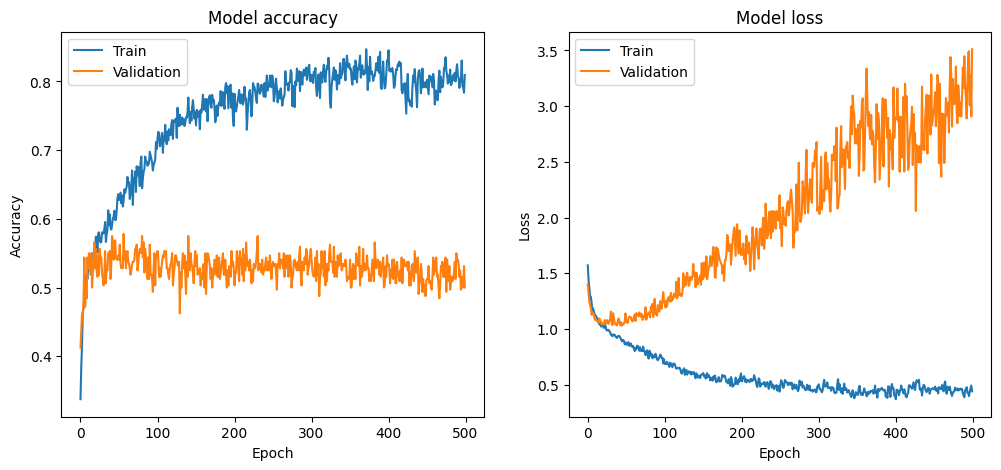

In [75]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Plot the training and validation accuracy/loss over epochs
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

#### Section Summary
The characteristics of this plot indicate a reasonable training scheme over the previous experiments. The presence of a minimum in the loss curve, X-axis suggests an optimal training duration (approx 250-300 epochs) that helps prevent overfitting (more epochs equate to more training). Excessive epochs may lead to overfitting.

For future experiments, variants that have been developed to cater to different needs and enhance performance should be considered. Here are some BERT variants:

1. Original BERT: The original BERT model introduced by Google, available in two sizes:

  a. BERT-Base: 12 layers, 768 hidden units, 12 attention heads. (used here)
  
  b. BERT-Large: 24 layers, 1024 hidden units, 16 attention heads.

2. DistilBERT: A smaller, faster, and lighter version of BERT, distilled to reduce size while retaining 97% of the performance of BERT.

3. RoBERTa (Robustly optimized BERT approach): An optimized version of BERT with more training data and hyperparameter tuning, resulting in improved performance over the original BERT.

4. ALBERT (A Lite BERT): A more efficient version of BERT that reduces memory consumption and increases the training speed by sharing parameters across layers and factorizing the embedding parameters.

5. XLNet: A generalized autoregressive pretraining method that outperforms BERT on various NLP tasks by capturing bidirectional contexts.

6. mBERT (Multilingual BERT): A BERT model trained on 104 different languages with a shared vocabulary, enabling cross-lingual NLP tasks.


# Conclusion

## Essay Grading Model Comparison

<style>
    .heatMap {
        width: 80%;
        #text-align: center;
    }
    .heatMap th {
        background: light grey;
        #word-wrap: break-word;
        text-align: center;
    }
    .heatMap tr:nth-child(1) { background: white; }
    .heatMap tr:nth-child(2) { background: light grey; }
    .heatMap tr:nth-child(3) { background: white; }
    .heatMap tr:nth-child(4) { background: light grey; }
</style>

<div class="heatMap">

| Vector      | Model | Sample Size | Train Accuracy | Test Accuracy |
| :---:      |    :----: |  :---: | :---:    | :----:   |
| TF-IDF  | Neural Network   | 6000    | 88.5%      | 41.4%      |
| TF-IDF  | K-Means   | 6000    |  100.0%     | 41.2%      |
| BERT| BERT   | 2000 |  84.6%      | 52.8%    |

</div>
<br>

This analysis reveals key insights into the performance of various essay grading models utilizing different vectorization techniques and architectures. The TF-IDF vectorization combined with a neural network achieved a high training accuracy of 88.5%, yet its test accuracy dropped significantly to 41.4%, indicating potential overfitting. Conversely, the TF-IDF with K-Means clustering achieved a perfect train accuracy of 100%, which is typical of clustering algorithms when labeling training data, but it matched the neural network's test accuracy at 41.2%, suggesting it does not generalize well to new data.

Notably, the BERT-based model, despite being trained on a smaller sample size of 2000 essays, demonstrated a more balanced performance with a training accuracy of 84.6% and a testing accuracy of 52.8%. This underscores the superiority of transformer-based models in handling complex linguistic data, as BERT excels in understanding context and semantics, providing more reliable and generalizable predictions. Thus, while traditional methods like TF-IDF can perform well in controlled training environments, advanced models like BERT are more effective for real-world applications in automated essay scoring due to their robust performance and superior handling of intricate language patterns.

# Summary

The objective was to develop an automated essay scoring model leveraging different machine learning techniques. The analysis involved three models: a Neural Network with TF-IDF vectorization, K-Means clustering with TF-IDF vectorization, and a BERT-based model.

#### **Key Findings:**
<ol>
  <li><strong>
TF-IDF Vectorization with Neural Network</strong></ol>

Evaluation Metrics:
<ul>
<li>Train Accuracy: 88.5%
<li>Test Accuracy: 41.4%
</ul>

Observation: High training accuracy with significantly lower test accuracy indicates overfitting.

<ol start ="2">
<li><strong>
TF-IDF Vectorization with K-Means Clustering</strong>
</ol>

Evaluation Metrics:
<ul>
<li>Train Accuracy: 100%
<li>Test Accuracy: 41.2%
</ul>

Observation: Perfect train accuracy due to the nature of clustering but poor generalization to test data, highlighting overfitting.

<ol start ="3">
<li><strong>
BERT-Based Model</strong>
</ol>

Evaluation Metrics:
<ul>
<li>Train Accuracy: 84.6%
<li>Test Accuracy: 52.8%
</ul>

Observation: Balanced performance with a higher test accuracy, indicating better generalization capabilities.

#### **Recommendations**
<ul>
<li><strong>Adopt the BERT-Based Model</strong>

Justification: The BERT model demonstrated the best balance between train and test accuracy, indicating strong generalization capabilities.
<li><strong>Mitigate Overfitting in Neural Network Models</strong>

Strategies: Consider regularization techniques, dropout adjustments, or tuning hyperparameters such as learning rate and batch size to improve generalization.
<li><strong>Expand Training Data</strong>

Rationale: Increasing the sample size can help in reducing overfitting and improving the model's ability to generalize to new data.
<li><strong>Further Explore Transformer-Based Models</strong>

Reasoning: Given the superior performance of the BERT model, exploring other transformer architectures or fine-tuning strategies could yield even better results.
<li><strong>Continuous Monitoring and Validation</strong>

Action: Regularly update the model with new data and validate its performance to ensure it remains effective and relevant.
</ul>

By implementing these recommendations, the goal of providing reliable and efficient automated essay scoring can be achieved, ultimately supporting educators in delivering timely and consistent feedback to students.








# Experimental Limitations

**Experimental Limitations
Subjective Interpretation of Grading Rubric:**

The essays were originally graded by multiple human evaluators, each with their own subjective interpretation of the grading rubric. This introduces variability and potential bias in the training labels, which can affect the model's ability to learn consistent scoring patterns.

**Dataset Size and Diversity:**

While the dataset is the largest open-access collection available, it may still not fully capture the diversity of student writing styles, topics, and difficulty levels found in real-world educational settings. This limitation can impact the generalizability of the model to broader populations.

**Potential Algorithmic Bias:**

Despite efforts to include samples across economic and geographic populations, there is still a risk of algorithmic bias. The model might inadvertently learn and perpetuate biases present in the training data, leading to unfair scoring for certain groups of students.

**Computational Resource Constraints:**

The extensive computational resources required for training complex models, such as BERT with numerous layers and nodes, may not be readily available to all researchers or educators. This constraint limits the ability to fully explore and fine-tune the most advanced model architectures.

**Training Time and Overfitting:**

Increasing the length of training epochs and model complexity can lead to overfitting, where the model performs well on training data but poorly on unseen test data. Balancing training time and avoiding overfitting is a challenging aspect of this experimental setup.

**Data Preprocessing Variability:**

The preprocessing steps, such as tokenization and stop-word removal, can introduce variability in the input data. Differences in preprocessing techniques can affect the consistency and quality of the input representations fed into the models.


# Next Steps

By implementing these specific actions, the goal is to systematically enhance the model's capacity, optimize its training process, and increase its complexity to achieve better accuracy and generalization in essay scoring.

1. **Increase Model Capacity:**

  **a. Expand the neural network with more layers and nodes:**

  Current Model: Utilize a neural network with a few layers and hundreds of nodes.
  
  Next Step: Develop a more complex architecture with significantly more layers (e.g., 100 layers) and thousands of nodes per layer (e.g., 1,000 nodes per layer). This would allow the model to capture more intricate patterns in the data.

  **b. Move from a few layers and hundreds of nodes to hundreds of layers and thousands of nodes:**

  Plan to incrementally increase the number of layers and nodes to find an optimal architecture that balances complexity and performance. For example, start by increasing to 10 layers with 500 nodes each, then 50 layers with 1,000 nodes each, and so on.

2. **Optimize Training Process:**

  **a. Increase the length of training epochs:**

  Current Training: Train the model for a moderate number of epochs (e.g., 50 epochs).

  Next Step: Extend the training duration to several hundred epochs (e.g., 300-500 epochs) to ensure thorough learning of the data patterns. Monitor for signs of overfitting and adjust early stopping criteria accordingly.

  **b. Allocate more computational resources to enable extensive training and improve accuracy:**

  Current Resources: Utilize standard GPU resources for training.

  Next Step: Upgrade to more powerful computational resources, such as Tensor Processing Units (TPUs) or multiple high-end GPUs. This will facilitate faster training times and allow for more extensive hyperparameter tuning and experimentation.

3. **Enhance Model Complexity:**

  **a. Scale up the model from word-based to sentence-based embeddings:**

  Current Approach: Use word-based embeddings (e.g., TF-IDF or BERT word embeddings).

  Next Step: Implement sentence-based embeddings using models like Sentence-BERT or Universal Sentence Encoder, which capture contextual information at the sentence level.

  **b. Experiment with paragraph-level embeddings for more context-aware analysis:**

  Current Approach: Focus on individual sentences or words.

  Next Step: Incorporate paragraph-level embeddings using hierarchical attention networks or advanced transformer models that consider larger text segments, providing deeper contextual understanding.

  **c. Incorporate additional BERT models or other transformer architectures:**

  Current Model: Use a standard BERT model.
  
  Next Step: Explore other pre-trained transformer models like RoBERTa, GPT-3, or T5 for essay scoring. Experiment with fine-tuning these models on the specific dataset to compare performance improvements.



# References

1. https://www.geeksforgeeks.org/lightgbm-light-gradient-boosting-machine/
2. https://www.kaggle.com/
3. https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2/overview
4. https://www.kaggle.com/code/raviiloveyou/sbert-aes/notebook
5. https://www.kaggle.com/code/awsaf49/aes-2-0-kerasnlp-starter
6. https://storage.googleapis.com/kaggle-forum-message-attachments/2733927/20538/Rubric_%20Holistic%20Essay%20Scoring.pdf
7. https://www.tensorflow.org/guide/keras/training_with_built_in_methods
8. https://keras.io/api/utils/
9. https://keras.io/search.html?query=from%20keras.utils%20import%20to_categorical
10. https://keras.io/search.html?query=to_categorical
11. https://huggingface.co/transformers/v3.0.2/main_classes/model.html#transformers.PreTrainedModel.from_pretrained
12. https://www.youtube.com/watch?v=JJYZ3OE_lGo
13. https://www.youtube.com/watch?v=p6yvuST_6oQ
14. https://medium.com/nlplanet/a-brief-timeline-of-nlp-from-bag-of-words-to-the-transformer-family-7caad8bbba56
15. https://keras.io/keras_nlp/
16. https://www.nltk.org/howto/framenet.html
17. https://medium.economist.com/why-you-sometimes-need-to-break-the-rules-in-data-viz-4d8ece284919
18. https://www.geeksforgeeks.org/understanding-tf-idf-term-frequency-inverse-document-frequency/
19. https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer
20. https://sbert.net/#:~:text=Sentence%20Transformers%20(a.k.a.,%2DEncoder%20models%20(quickstart).
21. https://towardsdatascience.com/deep-dive-into-the-code-of-bert-model-9f618472353e
22. https://keras.io/api/keras_tuner/tuners/bayesian/
23. https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate
24. https://stackoverflow.com/questions/50670920/how-to-insert-an-inline-image-in-google-colaboratory-from-google-drive/50672083#50672083
25. https://colab.research.google.com/notebooks/markdown_guide.ipynb#scrollTo=w86a4I4fmkvD
26. https://colab.research.google.com/notebooks/basic_features_overview.ipynb#scrollTo=qM4myQGfQboQ
27. https://github.com/markedjs/marked
28. https://graphviz.org/doc/info/attrs.html#undir_note
29. https://www.youtube.com/watch?v=4BOtr1PZ2D8
30. https://medium.economist.com/why-you-sometimes-need-to-break-the-rules-in-data-viz-4d8ece284919


